# Import danych

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from matplotlib import pyplot
from sklearn.utils import shuffle
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


from keras import backend as K
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
K.clear_session()
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 48} , log_device_placement=True )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)



warnings.filterwarnings("ignore")

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:03:00.0, compute capability: 6.1



In [2]:
train_audio_path = 'input/train/audio/'
model_path = 'model/'


# Funkcje

## Wybór zbioru treningowego i walidacyjnego

In [3]:
def getTrainAndValidationSet(all_wave,y):
  return train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

## Metryki

In [4]:
def print_metrics(history,pred,original_labels,classes):
  plotDiagnosticChart(history)
  print_confusion_matrix(pred,original_labels,classes)
  print_classification_report(pred,original_labels,classes)

## Wykres diagnostczny

In [5]:
def plotDiagnosticChart(history):
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

## Trening i testowaie na zbiorze walidacyjnym

In [6]:
def trainAndTest(model,x_tr,y_tr,x_val,y_val,es,mc):
  history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))
  return history

## Funkcję znajdująca wyraz odpowiadający sygnałowi audio

In [7]:
def predict(model,audio,classes):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

## Raport klasyfikacji

In [8]:
def print_classification_report(pred,original_labels,classes):
  print(classification_report(original_labels, pred, labels=classes))

## Macierz pomyłek

In [9]:
  def print_confusion_matrix(pred,original_labels,classes):
    cf_matrix = confusion_matrix(original_labels, pred, labels=classes)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
              fmt='.2%', cmap='Blues',
              xticklabels=classes,
              yticklabels=classes)

# Wybór 5 słów i preprocessing

## Wylosowanie 5 słów

Losowo wybrane 5 słów

In [10]:
random_labels = os.listdir(train_audio_path)
print(random_labels)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']


Ilość nagrań dla wybranych 5 słów

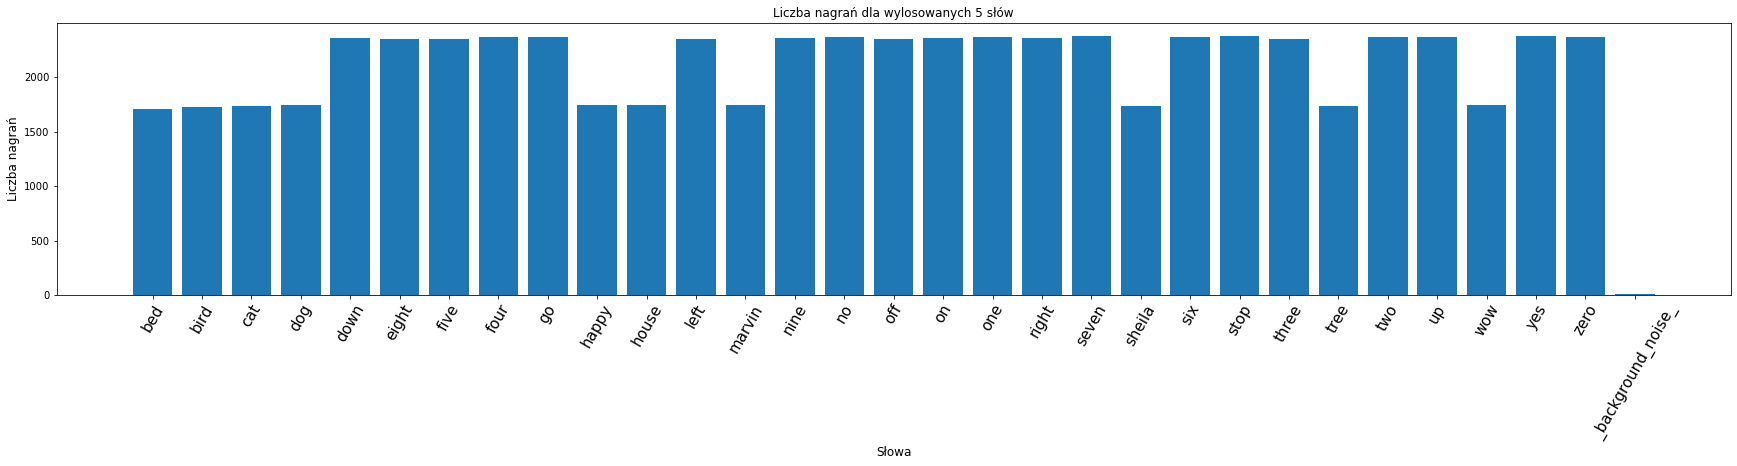

In [11]:
no_of_recordings=[]
for label in random_labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
plt.figure(figsize=(30,5))
index = np.arange(len(random_labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Słowa', fontsize=12)
plt.ylabel('Liczba nagrań', fontsize=12)
plt.xticks(index, random_labels, fontsize=15, rotation=60)
plt.title('Liczba nagrań dla wylosowanych 5 słów')
plt.show()

## Preprocessing

Resampling nagrań o długości 1s do częstotliwości 8 tys HZ 

In [12]:
all_wave = []
all_label = []
for label in random_labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

bed
bird
cat
dog
down
eight
five
four
go
happy
house
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
three
tree
two
up
wow
yes
zero
_background_noise_


In [13]:
%store -r all_wave
%store -r all_label

Konwersja etykiet tekstowych do kodów całkowitoliczbowych

In [14]:
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

 Konwersja całkowitoliczbowych etykiet do jednego wektora



In [15]:
y=np_utils.to_categorical(y, num_classes=len(random_labels))

# Sieć

Budowa modelu

In [16]:
def createModel():
  K.clear_session()
  inputs = Input(shape=(8000,1))

  #First Conv1D layer
  conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Third Conv1D layer
  conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Fourth Conv1D layer
  conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Flatten layer
  conv = Flatten()(conv)

  #Dense Layer 1
  conv = Dense(256, activation='relu')(conv)
  conv = Dropout(0.3)(conv)

  #Dense Layer 2
  conv = Dense(128, activation='relu')(conv)
  conv = Dropout(0.3)(conv)

  outputs = Dense(len(random_labels), activation='softmax')(conv)

  model = Model(inputs, outputs)

  return model

# Zadanie 1

best_model500.hdf5
Rozmiar zbioru treningowego: 500
Epoch 1/100
13/13 [==============================] - 6s 178ms/step - loss: 3.2658 - accuracy: 0.0908 - val_loss: 2.9082 - val_accuracy: 0.1300

Epoch 00001: val_accuracy improved from -inf to 0.13000, saving model to model\best_model500.hdf5
Epoch 2/100
13/13 [==============================] - 0s 23ms/step - loss: 2.6477 - accuracy: 0.1335 - val_loss: 2.6652 - val_accuracy: 0.1400

Epoch 00002: val_accuracy improved from 0.13000 to 0.14000, saving model to model\best_model500.hdf5
Epoch 3/100
13/13 [==============================] - 0s 27ms/step - loss: 2.5172 - accuracy: 0.1002 - val_loss: 2.5530 - val_accuracy: 0.1400

Epoch 00003: val_accuracy did not improve from 0.14000
Epoch 4/100
13/13 [==============================] - 0s 25ms/step - loss: 2.4477 - accuracy: 0.1294 - val_loss: 2.5538 - val_accuracy: 0.1400

Epoch 00004: val_accuracy did not improve from 0.14000
Epoch 5/100
13/13 [==============================] - 0s 23ms/step 

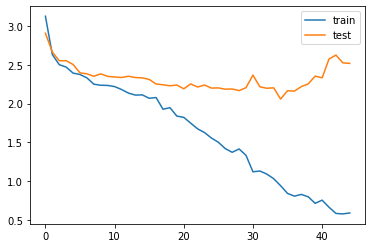

              precision    recall  f1-score   support

        down       0.34      0.39      0.36       430
          go       0.25      0.24      0.25       420
        left       0.15      0.21      0.18       433
          no       0.28      0.31      0.30       420
         off       0.40      0.44      0.42       429
          on       0.40      0.43      0.41       421
       right       0.28      0.17      0.22       431
        stop       0.35      0.25      0.29       435
          up       0.35      0.16      0.21       412
         yes       0.28      0.41      0.33       432

    accuracy                           0.30      4263
   macro avg       0.31      0.30      0.30      4263
weighted avg       0.31      0.30      0.30      4263

best_model800.hdf5
Rozmiar zbioru treningowego: 800
Epoch 1/100
20/20 [==============================] - 2s 37ms/step - loss: 3.0614 - accuracy: 0.1122 - val_loss: 2.6521 - val_accuracy: 0.1500

Epoch 00001: val_accuracy improved from -inf t

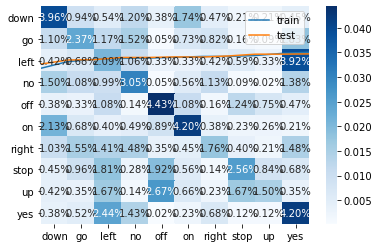

              precision    recall  f1-score   support

        down       0.46      0.17      0.25       430
          go       0.27      0.36      0.30       420
        left       0.22      0.19      0.20       433
          no       0.41      0.13      0.20       420
         off       0.36      0.53      0.43       429
          on       0.49      0.40      0.44       421
       right       0.35      0.25      0.29       431
        stop       0.24      0.51      0.33       435
          up       0.42      0.19      0.26       412
         yes       0.36      0.54      0.43       432

    accuracy                           0.33      4263
   macro avg       0.36      0.33      0.31      4263
weighted avg       0.36      0.33      0.31      4263

best_model1100.hdf5
Rozmiar zbioru treningowego: 1100
Epoch 1/100
28/28 [==============================] - 2s 34ms/step - loss: 3.0851 - accuracy: 0.0915 - val_loss: 2.6344 - val_accuracy: 0.1273

Epoch 00001: val_accuracy improved from -inf

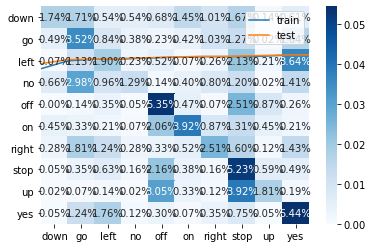

              precision    recall  f1-score   support

        down       0.50      0.48      0.49       430
          go       0.46      0.36      0.40       420
        left       0.36      0.20      0.26       433
          no       0.59      0.43      0.50       420
         off       0.38      0.51      0.44       429
          on       0.46      0.71      0.56       421
       right       0.52      0.36      0.43       431
        stop       0.38      0.37      0.37       435
          up       0.47      0.35      0.40       412
         yes       0.40      0.66      0.49       432

    accuracy                           0.44      4263
   macro avg       0.45      0.44      0.43      4263
weighted avg       0.45      0.44      0.43      4263

best_model1400.hdf5
Rozmiar zbioru treningowego: 1400
Epoch 1/100
35/35 [==============================] - 2s 30ms/step - loss: 3.1036 - accuracy: 0.0674 - val_loss: 2.5255 - val_accuracy: 0.0929

Epoch 00001: val_accuracy improved from -inf

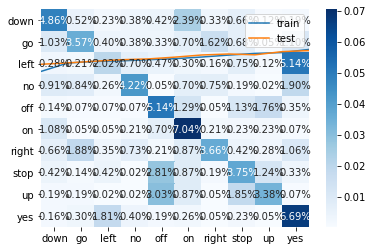

              precision    recall  f1-score   support

        down       0.65      0.49      0.56       430
          go       0.42      0.54      0.47       420
        left       0.54      0.48      0.51       433
          no       0.64      0.53      0.58       420
         off       0.67      0.61      0.64       429
          on       0.64      0.76      0.70       421
       right       0.81      0.66      0.72       431
        stop       0.50      0.65      0.57       435
          up       0.58      0.56      0.57       412
         yes       0.65      0.68      0.66       432

    accuracy                           0.60      4263
   macro avg       0.61      0.60      0.60      4263
weighted avg       0.61      0.60      0.60      4263

best_model1700.hdf5
Rozmiar zbioru treningowego: 1700
Epoch 1/100
43/43 [==============================] - 3s 28ms/step - loss: 2.9940 - accuracy: 0.0818 - val_loss: 2.6089 - val_accuracy: 0.1206

Epoch 00001: val_accuracy improved from -inf

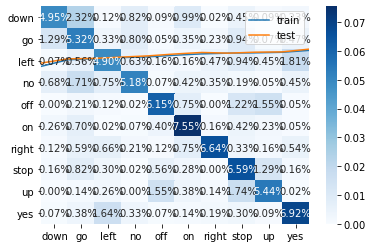

              precision    recall  f1-score   support

        down       0.68      0.48      0.57       430
          go       0.39      0.31      0.34       420
        left       0.35      0.28      0.31       433
          no       0.56      0.45      0.50       420
         off       0.72      0.58      0.64       429
          on       0.73      0.59      0.65       421
       right       0.64      0.63      0.63       431
        stop       0.62      0.59      0.61       435
          up       0.59      0.54      0.56       412
         yes       0.36      0.88      0.52       432

    accuracy                           0.53      4263
   macro avg       0.56      0.53      0.53      4263
weighted avg       0.56      0.53      0.53      4263

best_model2000.hdf5
Rozmiar zbioru treningowego: 2000
Epoch 1/100
50/50 [==============================] - 2s 25ms/step - loss: 2.9478 - accuracy: 0.0835 - val_loss: 2.4458 - val_accuracy: 0.1050

Epoch 00001: val_accuracy improved from -inf

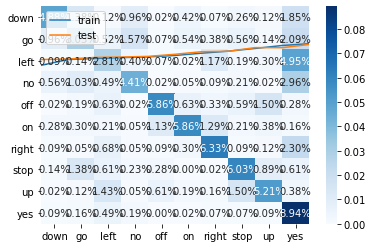

              precision    recall  f1-score   support

        down       0.69      0.58      0.63       430
          go       0.53      0.42      0.47       420
        left       0.42      0.41      0.42       433
          no       0.62      0.68      0.64       420
         off       0.65      0.68      0.67       429
          on       0.73      0.78      0.75       421
       right       0.66      0.69      0.68       431
        stop       0.53      0.58      0.56       435
          up       0.66      0.51      0.58       412
         yes       0.57      0.73      0.64       432

    accuracy                           0.61      4263
   macro avg       0.61      0.61      0.60      4263
weighted avg       0.61      0.61      0.60      4263



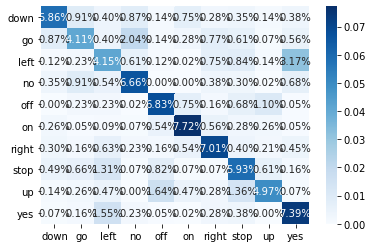

In [17]:
all_wave = np.array(all_wave)
X_tr, X_test, Y_tr, Y_test = train_test_split(all_wave, y,stratify=y,test_size = 0.2,random_state=666,shuffle=True)

for size in range(500,2300,300):
  model = createModel()
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
  print(f"best_model{size}.hdf5") 
  mc = ModelCheckpoint(f"{model_path}best_model{size}.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  print('Rozmiar zbioru treningowego: ' + str(size))
  wav = X_tr[:size,:]
  new_y = Y_tr[:size,:]
  wav = np.array(wav).reshape(-1,8000,1)

  x_tr, x_val, y_tr, y_val = getTrainAndValidationSet(wav,new_y)
  history = trainAndTest(model,x_tr,y_tr,x_val,y_val,es,mc)

  model=load_model(f"{model_path}best_model{size}.hdf5")
  pred = [predict(model, sample, classes) for sample in X_test]
  original_labels = [classes[np.argmax(label)] for label in Y_test]

  print_metrics(history,pred,original_labels,classes)
  

  



##